<a href="https://colab.research.google.com/github/LaloGarces/DeepDream-Algorithm/blob/main/Deep_Dream_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Dream Algorithm (AI Art) by [@Lalo Garcés](https://www.linkedin.com/in/eduardogarces1/)


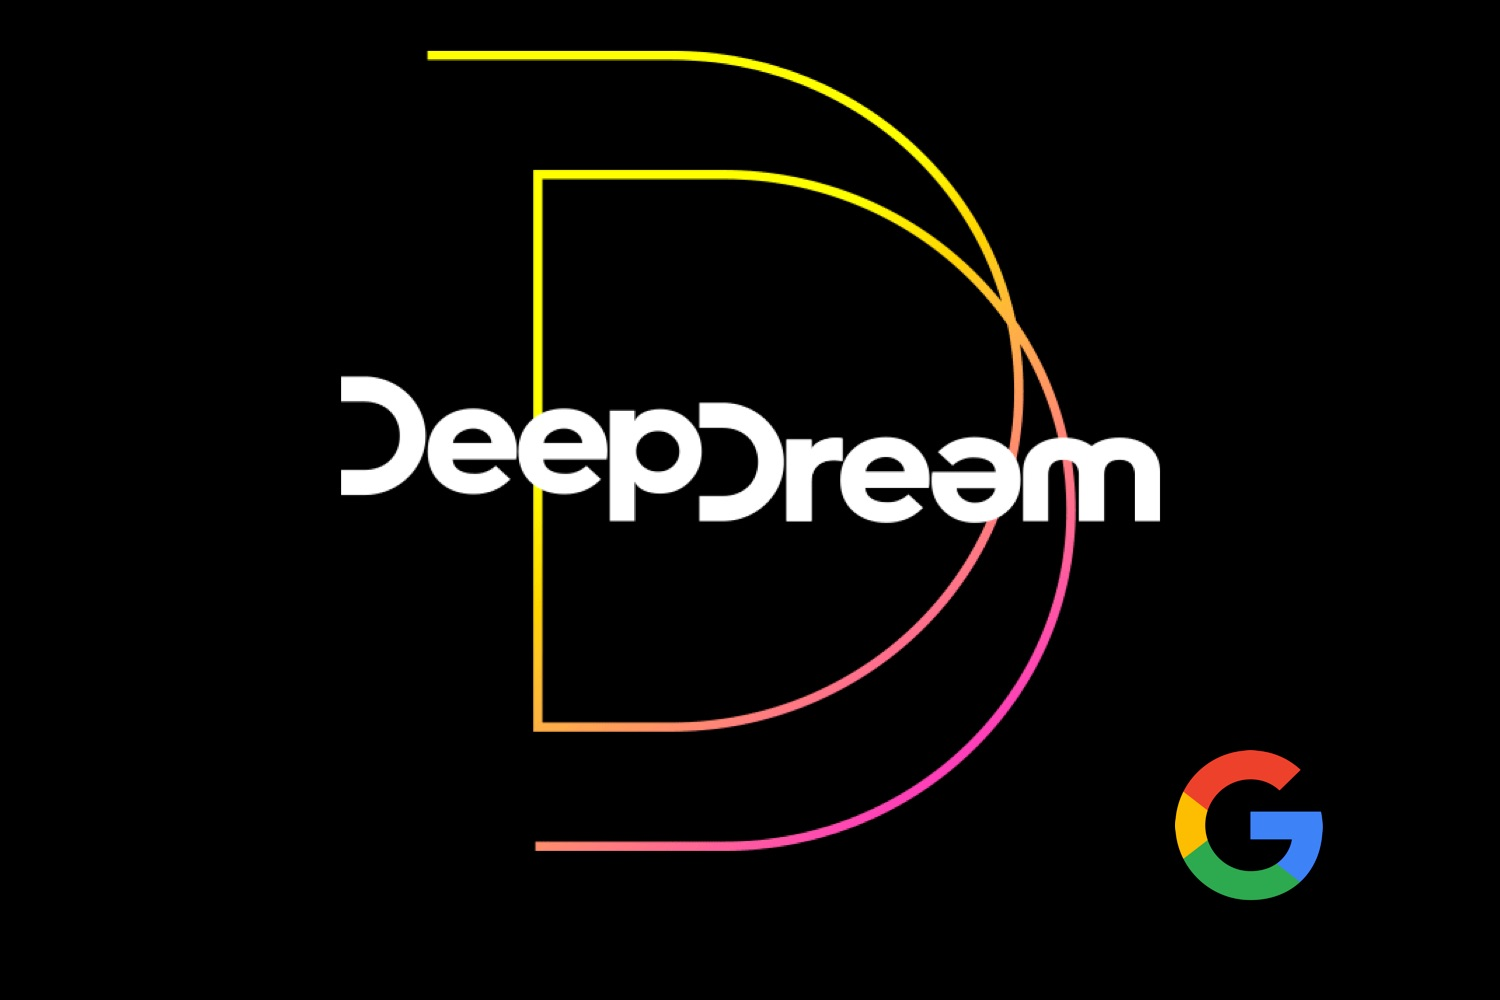

# Importing the necesary libraries


In [1]:
#You need to share access to your Google Drive account to Colab. 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Verify the GPU provided by Colab. 
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6a55f18c-3be9-1005-1777-c9d11aeabfbf)


In [3]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import os
import PIL.Image #--> This library, let us manipulate in an easy manner images in different formats. 
import cv2
import random
from PIL import Image

In [4]:
#Just verifying the version of our Tensorflow ecosystem. 
tf.__version__

'2.8.2'


---

---


Ok guys so, here we're going to cover some important topics 🔔

We're going to use **Transfer Learning, Inception model & ImageNet datastet**. 


* ✅  ***Transfer Learning***: Remember that transfer learning, is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task, always related to the same task. 

* ✅ ***Inception Model V3***: Is an image recognition model that presents a highly more accurate performance with the dataset ImageNet.

* ✅ ***ImageNet***: Is a dataset with millions of images used for image recognition tasks. 

---

---


In [5]:
#include_top = False, is related to exclude the first layer of the neural net. 
model = tf.keras.applications.InceptionV3(include_top = False, weights = 'imagenet')

87924736/87910968 [==============================] - 0s 0us/step


In [6]:
#Just to look how many parameters the model to use has. "More than 21M! Excluding the Top"
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

# Start Pre-Processing our Image

In this part, we're going to start developing "basic" Art , just mixing 2 images and see what we get with the algorithm. 

The images that I'm going to use, *were developed* in **Stable Diffusion** by me, so let's see the combination ⚡

In [7]:
# Open the first image (Please use your own images within your own Google Drive to run the next image)
img_babies_bitcoin = Image.open('/content/drive/MyDrive/AI/Images/cute_babies_bitcoin.jpg')

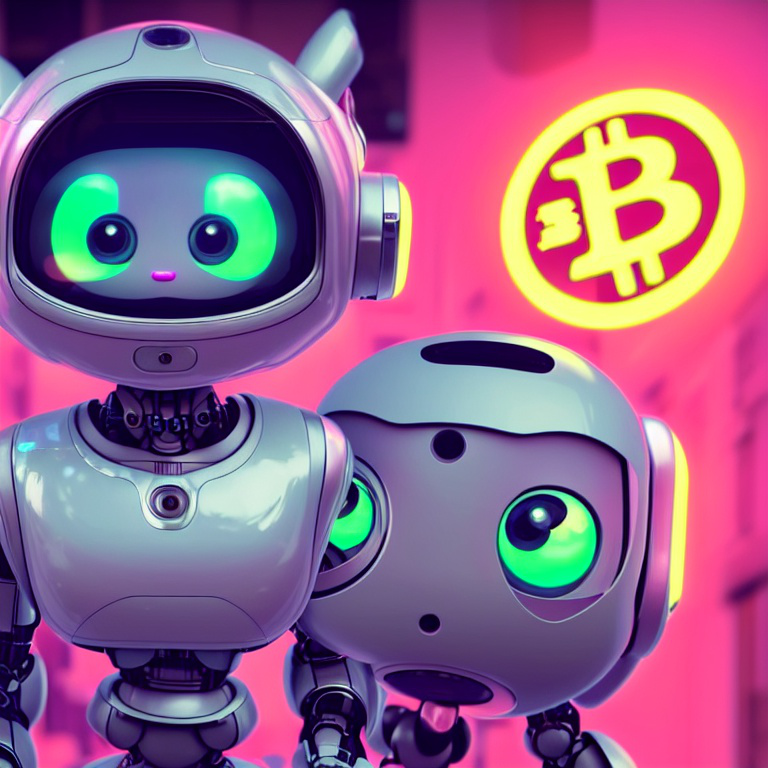

In [8]:
img_babies_bitcoin

In [9]:
# Open the second image (Please use your own images within your own Google Drive to run the next image)
img_cyberpunk = Image.open('/content/drive/MyDrive/AI/Images/cyberpunk.jpg')

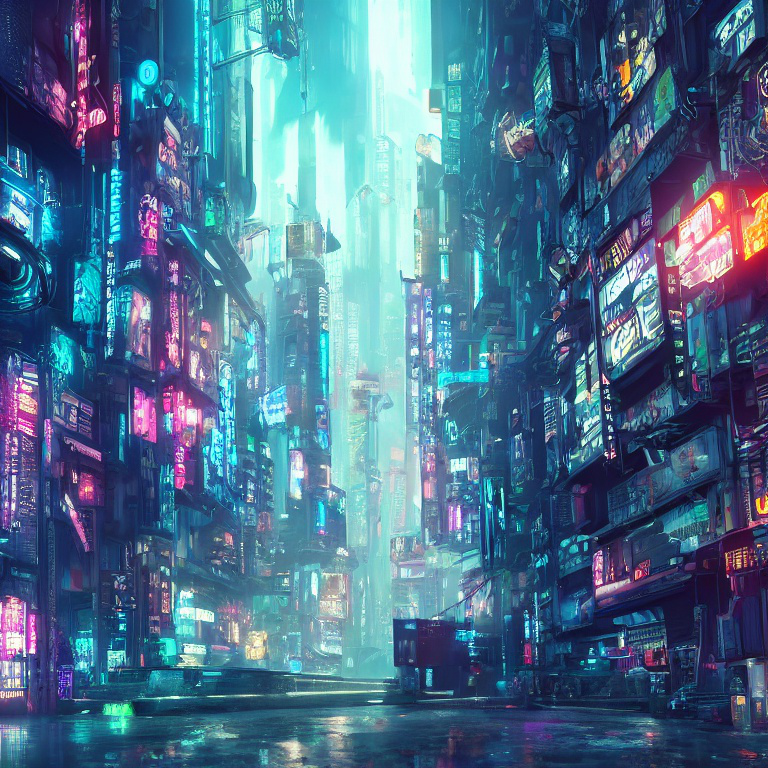

In [10]:
img_cyberpunk

Now let's blend the 2 images. 

# **In the interpolation alpha number, we're going to use = 0.5. **

Just to know, If alpha is 0.0, a copy of the first image is returned. If alpha is 1.0, a copy of the second image is returned. So 0.5 is the perfect balance to get 50% and 50% of both images

In [11]:
# Blend the two images
blend_image = Image.blend(img_babies_bitcoin, img_cyberpunk, 0.4) #--> Alpha 0.4 (I decided for a better look!)

# Save the blended image
blend_image.save("img_mix.jpg")

In [12]:
# Loading blended image
Mixed_Image = tf.keras.preprocessing.image.load_img('img_mix.jpg')

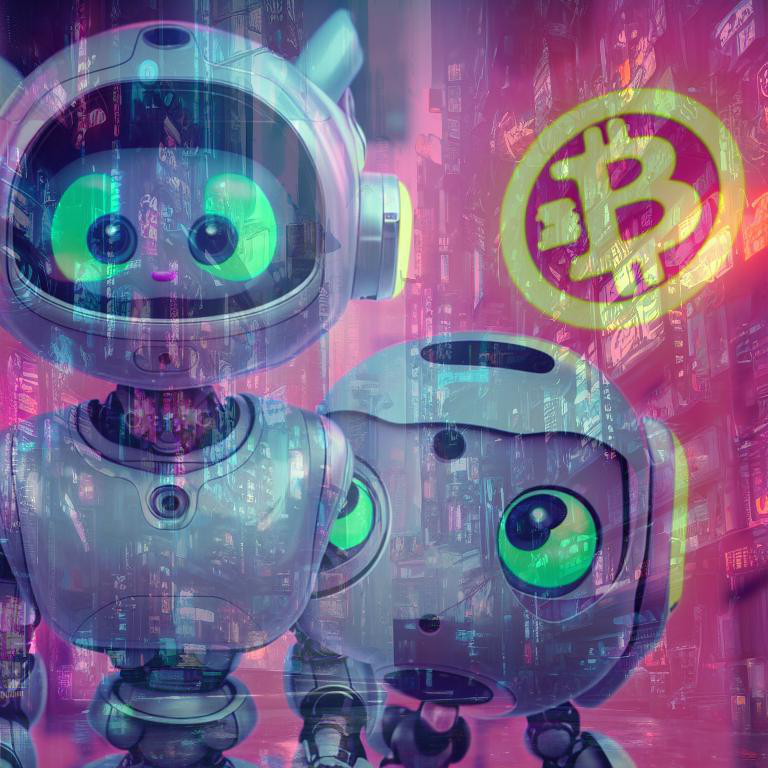

In [13]:
Mixed_Image

In [14]:
# Shape of the image (Getting 3 channels "colored image" : Red, Green and Blue)
np.shape(Mixed_Image)

(768, 768, 3)

In [15]:
# Check out the type of the image
type(Mixed_Image)

PIL.JpegImagePlugin.JpegImageFile

Here the image is PIL.Jpeg so we need to convert it, into a numpy array format. 

In [16]:
# Convert image into numpy array
Image = tf.keras.preprocessing.image.img_to_array(Mixed_Image)

In [17]:
# Confirm that the image is converted to numpy array
type(Image)

numpy.ndarray

To process correctly the image, we need to know if it's normalized. So here, we're going to verify the min and max number of pixel of the "Mixed_Image = Image"

In [18]:
# Max and min values
print('min pixel values = {}, max pixel values = {}'.format(Image.min(), Image.max()))

min pixel values = 0.0, max pixel values = 255.0


In [19]:
# Normalize the input of the image
Image = np.array(Image)/255.0
Image.shape

(768, 768, 3)

In [20]:
# Sanity check of the normalized image
print('min pixel values = {}, max pixel values = {}'.format(Image.min(), Image.max()))

min pixel values = 0.0, max pixel values = 1.0


In [21]:
Image = tf.expand_dims(Image, axis = 0)

In [22]:
np.shape(Image)

TensorShape([1, 768, 768, 3])

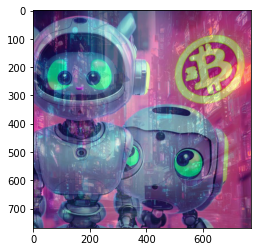

In [23]:
plt.imshow(np.squeeze(Image))

In [24]:
np.squeeze(Image).shape

(768, 768, 3)

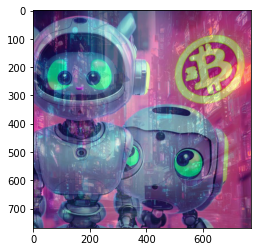

In [25]:
plt.imshow(np.squeeze(Image))

# Prepare our pretrained model & explore activation functions

**It's importnat to mention that, to maximize the loss in the model, we need to select the correct number of layers that perform better, avoiding to run *the* entire model that has +21M of parameters (Inception model V3).**

Early layers generate simple features. ✊
Deep layers generate more complex features such as entire face, car or tree. ✋

*Inception network has multiple concatenated layers named 'mixed'*

Just to refresh our minds, this model is a CNN, Convolutional Neural Network. In this images I put here how early layers just identify edges or shadows and deeper layers start representing in a more visible way the images. 

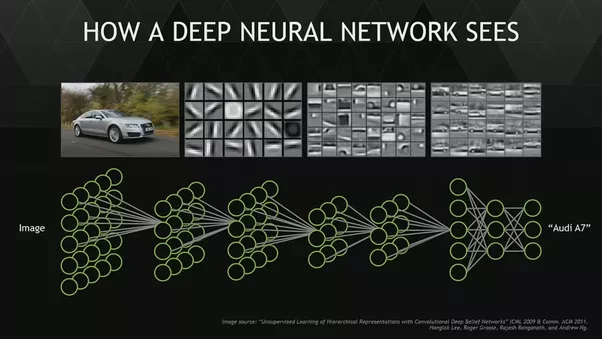

With Deep Dream algorithm, we're going to only **ask to each layers to maximize the output of each one**, having the results of a full colored phsycodellic image. ✅

In [26]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [27]:
# Maximize the activations of these layers
layers_ = ['mixed3', 'mixed5', 'mixed7']

# Name the layers (mixed 2, mixed 4, mixed 7) 3,5,7

layers = [model.get_layer(name).output for name in layers_]

# Create the feature extraction model
deepdream_algorithm = tf.keras.Model(inputs = model.input, outputs = layers)

In [28]:
deepdream_algorithm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [29]:
# Let's see and fit, how actually our Neuron looks in our image mixed image - "Neuron outputs"
#Hidden layers
activations = deepdream_algorithm(Image)
activations

[<tf.Tensor: shape=(1, 46, 46, 768), dtype=float32, numpy=
 array([[[[0.3462467 , 0.        , 0.        , ..., 0.        ,
           0.85148484, 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.23580402, 0.53909963],
          ...,
          [0.        , 0.        , 0.        , ..., 0.40346846,
           0.7275001 , 0.4850273 ],
          [1.2252172 , 0.        , 0.        , ..., 1.4417475 ,
           0.9957278 , 1.2191817 ],
          [4.008756  , 0.        , 0.        , ..., 1.4417475 ,
           0.99857587, 2.5793033 ]],
 
         [[0.        , 0.        , 0.        , ..., 0.28280324,
           0.38232788, 0.46321878],
          [0.        , 0.76323485, 0.        , ..., 0.        ,
           0.07784478, 0.46321878],
          [0.        , 0.7872514 , 0.        , ..., 0.        ,
           0.43042335, 0.53909963],
          ...,
        

In [30]:
len(activations)

3

3 len due ('mixed2', 'mixed4', 'mixed7')

# Before Start: How does the Deep Dream Algorithm works? 

Deep Dream is focused on try to maximize the activations of each layers of the Neural Network. 

In contrast of the methood we use regularly in Deep Learning, the gradient descent, Deep Dream uses **gradient ascent to maximize the activations in the network over the input image, having the result of phsycodellic images.**

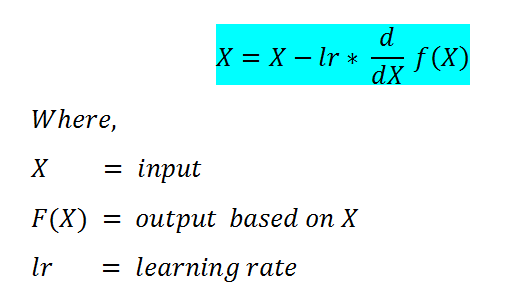

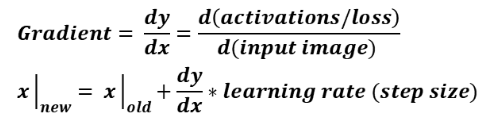

tf.GradientTape() is used to record operations for automatic differentiation

Calculating gradient of: y = X^4 + X^5 at X = 4


In [31]:
x = tf.constant(4.0) #--> The constant X=4

In [32]:
with tf.GradientTape() as g:
  g.watch(x)
  y = (x * x * x * x) + (x * x * x * x * x)  
dy_dx = g.gradient(y, x) 
dy_dx

<tf.Tensor: shape=(), dtype=float32, numpy=1536.0>

In [33]:
dy_dx

<tf.Tensor: shape=(), dtype=float32, numpy=1536.0>

# Calculating the loss of the model

Since, Deep Dream performs better increasing the loss, we're going to calculate the loss of the model. 

Like refresher, in simple terms, the Loss function is a method of evaluating how well your algorithm is modeling your dataset. It is a mathematical function of the parameters of the machine learning algorithm.

**If the value of the loss function is lower then it’s a good model otherwise, we have to change the parameter of the model and minimize the loss.**

In this case, we're going to do the opposite

In [34]:
Image.shape

TensorShape([1, 768, 768, 3])

In [35]:
#We need to reduce the dimension of the image
Image = tf.squeeze(Image, axis = 0)

In [36]:
Image.shape

TensorShape([768, 768, 3])

Here, we're going to calculate the avergaes and then the sum of all the losses of the network: 

In [37]:
def calc_loss(image, model):

  img_batch = tf.expand_dims(image, axis=0) # Convert into batch format
  layer_activations = model(img_batch) # Run the model
  print('ACTIVATION VALUES (LAYER OUTPUT) =\n', layer_activations)

  losses = [] # accumulator to hold all the losses
  for act in layer_activations:
    loss = tf.math.reduce_mean(act) # calculate mean of each activation 
    losses.append(loss)
  
  print('LOSSES (FROM MULTIPLE ACTIVATION LAYERS) = ', losses)
  print('LOSSES SHAPE (FROM MULTIPLE ACTIVATION LAYERS) = ', np.shape(losses))
  print('SUM OF ALL LOSSES (FROM ALL SELECTED LAYERS)= ', tf.reduce_sum(losses))

  return  tf.reduce_sum(losses) # Calculate sum 

In [38]:
#Verifying the loss within the Image (blended image) & the deepdream_algorithm (teh model) previously done. 
loss = calc_loss(tf.Variable(Image), deepdream_algorithm)

ACTIVATION VALUES (LAYER OUTPUT) =
 [<tf.Tensor: shape=(1, 46, 46, 768), dtype=float32, numpy=
array([[[[0.3462467 , 0.        , 0.        , ..., 0.        ,
          0.85148484, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.23580402, 0.53909963],
         ...,
         [0.        , 0.        , 0.        , ..., 0.40346846,
          0.7275001 , 0.4850273 ],
         [1.2252172 , 0.        , 0.        , ..., 1.4417475 ,
          0.9957278 , 1.2191817 ],
         [4.008756  , 0.        , 0.        , ..., 1.4417475 ,
          0.99857587, 2.5793033 ]],

        [[0.        , 0.        , 0.        , ..., 0.28280324,
          0.38232788, 0.46321878],
         [0.        , 0.76323485, 0.        , ..., 0.        ,
          0.07784478, 0.46321878],
         [0.        , 0.7872514 , 0.        , ..., 0.        ,
          0.43042335, 0.53909963],
       

In [39]:
loss # Sum up the losses from both activations

<tf.Tensor: shape=(), dtype=float32, numpy=0.6257201>

# Applying Deep Dream Algorithm & Calcute the Gradient Descent

In this step, we will rely on the loss that has been calculated in the previous step and calculate the gradient with respect to the given input image and then add it to the input original image.

*This code is to see the progress of each image; Each output of the image, is going to show us the loss, you're going to see when the loss increase, the more psychedellic the image.*


In [40]:
@tf.function
def deepdream(model, image, step_size):
    with tf.GradientTape() as tape:

      tape.watch(image)
      loss = calc_loss(image, model) #--> calc_loss is the one used to analyze the losses of the activations

    # The syntax is as follows: dy_dx = g.gradient(y, x) 
    gradients = tape.gradient(loss, image)

    print('GRADIENTS =\n', gradients)
    print('GRADIENTS SHAPE =\n', np.shape(gradients))

    # tf.math.reduce_std computes the standard deviation of elements across dimensions of a tensor
    gradients /= tf.math.reduce_std(gradients)  

    image = image + gradients * step_size
    image = tf.clip_by_value(image, -1, 1)

    return loss, image

In [41]:
def run_deep_dream_simple(model, image, steps = 100, step_size = 0.01):

  image = tf.keras.applications.inception_v3.preprocess_input(image)

  for step in range(steps):
    loss, image = deepdream(model, image, step_size)
    
    if step % 100 == 0:
      plt.figure(figsize=(12,12))
      plt.imshow(deprocess(image))
      plt.show()
      print ("Step {}, loss {}".format(step, loss))

  plt.figure(figsize=(12,12))
  plt.imshow(deprocess(image))
  plt.show()

  return deprocess(image)

In [42]:
def deprocess(image):
  image = 255*(image + 1.0)/2.0
  return tf.cast(image, tf.uint8)


In [43]:
Image.shape

TensorShape([768, 768, 3])

In [44]:
# Let's Load the image again and convert it to Numpy array 
Image = np.array(tf.keras.preprocessing.image.load_img('img_mix.jpg'))


In [45]:
Image.shape

(768, 768, 3)

In [ ]:
#You nee to install this version of numpy because if not, you get an error in the moment to convert the image. 
pip install numpy==1.19.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
#Remove the comments of the next code line to run Deep Dream Algorithm: 
#dream_img = run_deep_dream_simple(model = deepdream_algorithm, image = Image, steps = 7000, step_size = 0.001)

## *You can see in each image how the higher the loss, the more psychedelic the image, that is essentially the purpose of Deep Dream algorithm*